## Analyze Altitude Changes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

from utils import *
from georeg import *

### Helper Functions

In [12]:


def load_img_fn_and_meta(img_dir, count, start):
    df = pd.read_csv(img_dir + '/log.csv')
    df['filename'] = df['SourceFile'].str.split('/').str[-1]
    df = df.set_index('filename')
    #print(df.head())
    i = 0
    j = 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.tif"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            md = gpsphoto.getGPSData(file)
            filename = file.split('/')[-1]
            md['filename'] = filename
            # this isn't correctly loaded into the exifdata so pulling it into my own md
            md['yaw']   = (df.loc[filename]['    GPSImgDirection'] + 360) % 360
            md['pitch'] = (df.loc[filename]['GPSPitch'] + 360) % 360
            md['roll']  = (df.loc[filename]['GPSRoll'] + 360) % 360
            
            img_metadata.append(md)
            j += 1
        i += 1
        
    return(imgs, img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

In [3]:
surface_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude', 'stacks')

In [4]:
surface_dir + "/../*.tif"

'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/../*.tif'

In [22]:
def last_10chars(x):
    return(x[-10:])

img_fns = glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude') + "/*.tif")

img_fns = sorted(img_fns, key = last_10chars)
len(img_fns)

2034

In [6]:
surface_dir + '/../../../SYNLog-17-04-46_17-03-2021_edit.csv'

'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/../../../SYNLog-17-04-46_17-03-2021_edit.csv'

In [7]:
alta_logs = format_alta_logs(surface_dir + '/../../../SYNLog-17-04-46_17-03-2021_edit.csv')
alta_logs.head()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0,1,2,4,5,6,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Reading,IMU Time,Date,GPS Time,Unnamed: 4,Longitude,Latitude,GPS Height,GPS Course,GPS Pos N,...,Gyro Bias P,Gyro Bias Y,Accel Bias X,Accel Bias Y,Accel Bias Z,Extended Status,5V Alarm,Z Vibration,Checksum,id
dt,,,,,,,,,,,,,,,,,,,,,
2021-03-17 17:04:46.000000,27,1.012,20210317,17:04:46,NaN,-766727232,347156576,-1.55,18.3,-5.29,...,-33.1930,8.0274,0.0,0.0,0.215,0.0,0.0,0.03,172.0,0
2021-03-17 17:04:46.000001,28,1.052,20210317,17:04:46,NaN,-766727232,347156576,-1.55,18.3,-5.29,...,-33.1992,8.0271,0.0,0.0,0.215,0.0,0.0,0.03,1.0,1
2021-03-17 17:04:46.000002,29,1.092,20210317,17:04:46,NaN,-766727232,347156544,-1.54,18.3,-5.33,...,-33.2055,8.0282,0.0,0.0,0.215,0.0,0.0,0.03,170.0,2
2021-03-17 17:04:46.000003,30,1.132,20210317,17:04:46,NaN,-766727232,347156544,-1.54,18.3,-5.33,...,-33.2090,8.0281,0.0,0.0,0.215,0.0,0.0,0.03,208.0,3
2021-03-17 17:04:46.000004,31,1.172,20210317,17:04:46,NaN,-766727232,347156544,-1.54,18.3,-5.33,...,-33.2094,8.0337,-0.0,-0.0,0.215,0.0,0.0,0.03,161.0,4


In [8]:

mds = load_img_fn_and_meta(surface_dir, start=0)

# mds = load_img_fn_and_meta(surface_dir, start=0)
# len(mds)

In [10]:
start=0
count=30
sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=count, start=start, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [11]:
sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=count, start=start, altitude_cutoff=0)
for item in sea_img_metadata:
    utc_time = datetime.datetime.strptime('2021-03-17-' + item['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
    img_idx = alta_logs.index.get_loc(utc_time, method='nearest')
    item['log_id'] = img_idx
    item['alta_yaw'] = (alta_logs.iloc[img_idx]['Yaw'] + 360) % 360
    # then ensures
    item['image_name'] = img_fns[start*6+item['id']*6]

{'Latitude': 34.71551388888889, 'Longitude': -76.67275833333333, 'Altitude': 6.8, 'UTC-Time': '17:5:40', 'Date': '03/17/2021', 'full_filename': 'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/M4M8An3w56zQunPjrPpH.tif', 'filename': 'M4M8An3w56zQunPjrPpH.tif', 'yaw': 184.4742078073314, 'pitch': 3.228862137578176, 'roll': 6.800894301913388, 'id': 0}
{'Latitude': 34.71551388888889, 'Longitude': -76.67275833333333, 'Altitude': 6.7, 'UTC-Time': '17:5:42', 'Date': '03/17/2021', 'full_filename': 'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/GMdqoQ0esy5sXcRTNhgl.tif', 'filename': 'GMdqoQ0esy5sXcRTNhgl.tif', 'yaw': 184.59154914173888, 'pitch': 2.0028313767595023, 'roll': 8.195976384942412, 'id': 1}
{'Latitude': 34.71551111111111, 'Longitude': -76.67276111111111, 'Altitude': 6.5, 'UTC-Time': '17:5:44', 'Date': '03/17/2021', 'full_filename': 'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/XbL1PxFTPTmdHXR

In [12]:
mds[0]

{'Latitude': 34.71551388888889,
 'Longitude': -76.67275833333333,
 'Altitude': 6.8,
 'UTC-Time': '17:5:40',
 'Date': '03/17/2021',
 'full_filename': 'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/M4M8An3w56zQunPjrPpH.tif',
 'filename': 'M4M8An3w56zQunPjrPpH.tif',
 'yaw': 184.4742078073314,
 'pitch': 3.228862137578176,
 'roll': 6.800894301913388}

In [16]:
len(mds)

50

In [18]:
mds[30]

{'Latitude': 34.715500000000006,
 'Longitude': -76.67275833333333,
 'Altitude': 1,
 'UTC-Time': '17:6:50',
 'Date': '03/17/2021',
 'full_filename': 'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/CDQ8y17PCYKYsGT6P29e.tif',
 'filename': 'CDQ8y17PCYKYsGT6P29e.tif',
 'yaw': 184.1097792052729,
 'pitch': 1.35175619211077,
 'roll': 6.287057721799954}

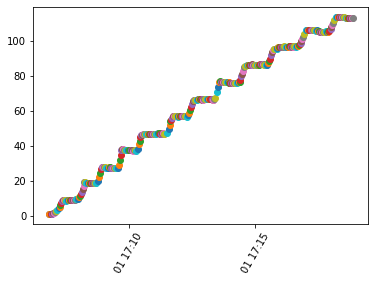

In [16]:
import datetime

for md in mds[30:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['Altitude'])
    plt.xticks(rotation=60)

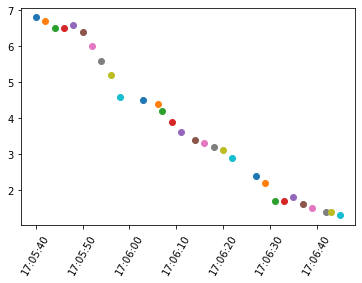

In [15]:
for md in sea_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['Altitude'])
    plt.xticks(rotation=60)

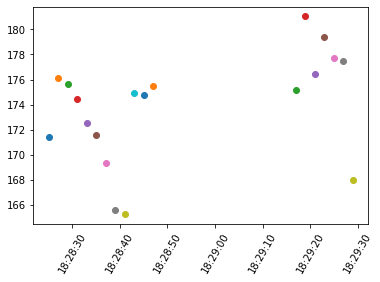

In [78]:
for md in sky_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['roll'])
    plt.xticks(rotation=60)

## Detect squares in each image

In [7]:
# import the necessary packages
import cv2
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

In [61]:
?np.arange

In [63]:
np.arange(39,39+10*5,5)

array([39, 44, 49, 54, 59, 64, 69, 74, 79, 84])

We need to write out some of the individual bands as tifs so I can pull them into ImageJ

In [54]:
import tifffile as tiff

In [76]:
sea_img_metadata[0]['image_name'].split('/')[-1][:-5]

'IMG_0170_'

In [74]:
sea_img_metadata[0]['full_filename']

'data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/IR78cnqau3xlTOckmr41.tif'

In [112]:
for start in np.arange(39,39+15*5,5):
    count = 1
    sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=count, start=start, altitude_cutoff=0)
    for item in sea_img_metadata:
        utc_time = datetime.datetime.strptime('2021-03-17-' + item['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
        img_idx = alta_logs.index.get_loc(utc_time, method='nearest')
        item['log_id'] = img_idx
        item['alta_yaw'] = (alta_logs.iloc[img_idx]['Yaw'] + 360) % 360
        # then ensures
        item['image_name'] = img_fns[start*6+item['id']*6]
    print(sea_img_metadata[0]['image_name'])
    print(sea_img_metadata[0]['filename'])

data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0100_1.tif
VO1nzxYiwuvEiiyo8Pg5.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0105_1.tif
EfuR192QXO4RYpVOws29.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0110_1.tif
nabCRLANORiB98xXRrd4.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0115_1.tif
ywrjLcxacY9Eitopfspy.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0120_1.tif
AhBzp1eV0xBT9lQa6sak.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0125_1.tif
sfFZkD2vocsQi9Vkv7vk.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0130_1.tif
0xhfuajFa1WgpgCYd2b9.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0135_1.tif
c5Y63ndCJZjl5P11c5Aa.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0140_1.tif
ENKWI0UcdkQmViLuWn4N.tif
d

In [79]:
for start in np.arange(39,39+15*5,5):
    count = 1
    sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=count, start=start, altitude_cutoff=0)
    for item in sea_img_metadata:
        utc_time = datetime.datetime.strptime('2021-03-17-' + item['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
        img_idx = alta_logs.index.get_loc(utc_time, method='nearest')
        item['log_id'] = img_idx
        item['alta_yaw'] = (alta_logs.iloc[img_idx]['Yaw'] + 360) % 360
        # then ensures
        item['image_name'] = img_fns[start*6+item['id']*6]
    print(sea_img_metadata[0]['image_name'])
#     print(sea_img_metadata[0]['filename'])
    src = rasterio.open(sea_img_metadata[0]['full_filename'])
    for i in range(1,6):
        image = src.read(i)
        tiff.imsave('data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/' + sea_img_metadata[0]['image_name'].split('/')[-1][:-5] + str(i) + '.tif', image)
    

data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0100_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0105_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0110_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0115_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0120_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0125_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0130_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0135_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0140_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0145_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0150_1.tif
data/20210317_duml_360_altitude_testing/altitude_test/

In [43]:
src_org = rasterio.open('data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0100_1.tif')

In [85]:
image = src_org.read(1)
image.shape, image.dtype

((1544, 2064), dtype('uint16'))

In [8]:
np.max(image)

65504

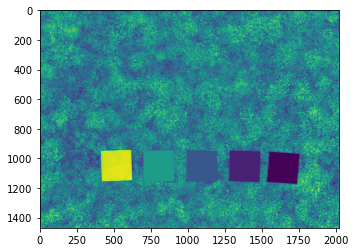

In [84]:
plt.imshow(image)

In [91]:
image.shape

(1544, 2064)

In [88]:
min(xy_arrays[i,:,0])

1578.0

In [108]:
int(xy_arrays[i,:,0].min()),int(xy_arrays[i,:,0].max()), int(xy_arrays[i,:,1].min()),int(xy_arrays[i,:,1].max())

(1578, 1706, 1016, 1144)

In [102]:
i=0

In [104]:
i=3

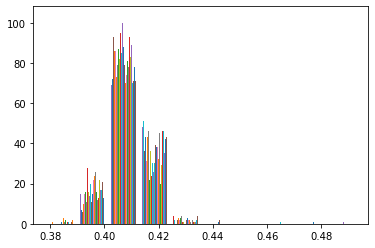

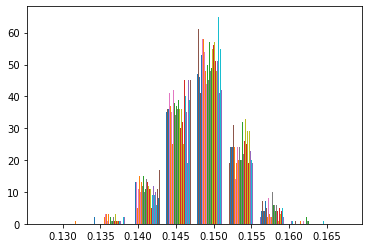

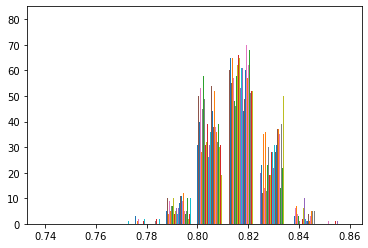

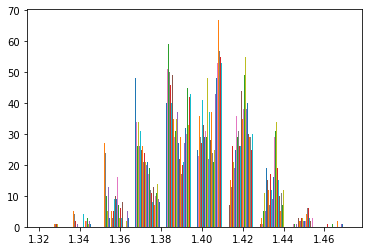

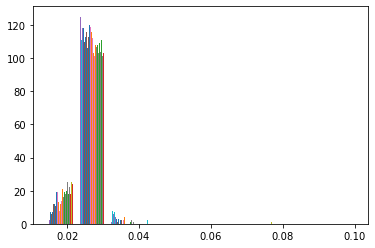

In [107]:
for i in range(5):
    plt.hist(image[int(xy_arrays[i,:,1].min()):int(xy_arrays[i,:,1].max()), int(xy_arrays[i,:,0].min()):int(xy_arrays[i,:,0].max())]/32750)
    plt.show()

In [119]:
xy_arrays.sort(axis=0)

In [122]:
xy_arrays

array([[[ 442.,  982.],
        [ 442., 1116.],
        [ 576., 1116.],
        [ 576.,  982.]],

       [[1026.,  992.],
        [1026., 1120.],
        [1154., 1120.],
        [1154.,  992.]],

       [[1322.,  992.],
        [1322., 1124.],
        [1454., 1124.],
        [1454.,  992.]],

       [[ 726.,  986.],
        [ 726., 1128.],
        [ 868., 1128.],
        [ 868.,  986.]],

       [[1576., 1002.],
        [1576., 1128.],
        [1702., 1128.],
        [1702., 1002.]]])

In [120]:
xy_arrays

array([[[ 442.,  982.],
        [ 442., 1116.],
        [ 576., 1116.],
        [ 576.,  982.]],

       [[ 726.,  986.],
        [ 726., 1120.],
        [ 868., 1120.],
        [ 868.,  986.]],

       [[1026.,  992.],
        [1026., 1124.],
        [1154., 1124.],
        [1154.,  992.]],

       [[1322.,  992.],
        [1322., 1128.],
        [1454., 1128.],
        [1454.,  992.]],

       [[1576., 1002.],
        [1576., 1128.],
        [1702., 1128.],
        [1702., 1002.]]])

In [125]:
xy_counter = 0
# this is a list of lists of lists
plaque_list_array = []
#for start in np.arange(39,39+15*5,5):
for start in [39]:
    count = 1
    sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=count, start=start, altitude_cutoff=0)
    for item in sea_img_metadata:
        utc_time = datetime.datetime.strptime('2021-03-17-' + item['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
        img_idx = alta_logs.index.get_loc(utc_time, method='nearest')
        item['log_id'] = img_idx
        item['alta_yaw'] = (alta_logs.iloc[img_idx]['Yaw'] + 360) % 360
        # then ensures
        item['image_name'] = img_fns[start*6+item['id']*6]
    print(sea_img_metadata[0]['image_name'])
#     print(sea_img_metadata[0]['filename'])
    src = rasterio.open(sea_img_metadata[0]['full_filename'])
    # this is a list of the lists of plaque values for each band in the image
    plaques_for_each_raster = []
    # iterate through each band in the raster
    for i in range(1,6):
        image = src.read(i)
        xy_arrays = np.genfromtxt(xy_fns[xy_counter]).reshape(5,4,2)
        # this is being sorted left to right so that it starts off with the brightest plaque
        # this only works because every image has the same yaw from the dronw
        xy_arrays.sort(axis=0)
        # iterate through each plaque in the image
        plaques = []
        for j in range(5):
#             plt.scatter(xy_arrays[j,:,0],xy_arrays[j,:,1])
            # here is where I will extract the values from the image
            plaques.append(image[int(xy_arrays[j,:,1].min()):int(xy_arrays[j,:,1].max()), int(xy_arrays[j,:,0].min()):int(xy_arrays[j,:,0].max())]/32750)
            #plt.hist(image[int(xy_arrays[j,:,1].min()):int(xy_arrays[j,:,1].max()), int(xy_arrays[j,:,0].min()):int(xy_arrays[j,:,0].max())]/32750)
            #plt.xlim(0,1.5)    
            #plt.show()
        plaques_for_each_raster.append(plaques)
#         plt.imshow(image)
#         plt.show()
        xy_counter +=1
    plaque_list_array.append(plaques_for_each_raster)

data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0100_1.tif


In [ ]:
for img in plaque_list_array:
    for

In [129]:
plaque_list_array

[[[array([[0.83978626, 0.83926718, 0.83874809, ..., 0.77254962, 0.77221374,
           0.77187786],
          [0.84003053, 0.83951145, 0.83899237, ..., 0.77276336, 0.77242748,
           0.7720916 ],
          [0.84027481, 0.83972519, 0.83920611, ..., 0.7729771 , 0.77264122,
           0.77230534],
          ...,
          [0.88717557, 0.88659542, 0.8860458 , ..., 0.81505344, 0.81471756,
           0.81438168],
          [0.88760305, 0.8870229 , 0.88644275, ..., 0.81541985, 0.81508397,
           0.81471756],
          [0.888     , 0.88745038, 0.88687023, ..., 0.81581679, 0.81545038,
           0.81508397]]),
   array([[0.67755725, 0.67047328, 0.66656489, ..., 0.65883969, 0.67169466,
           0.67728244],
          [0.67551145, 0.68433588, 0.6791145 , ..., 0.65654962, 0.67212214,
           0.66977099],
          [0.67129771, 0.6829313 , 0.68635115, ..., 0.65883969, 0.68467176,
           0.67807634],
          ...,
          [0.66467176, 0.66748092, 0.65621374, ..., 0.65496183, 0.65

In [110]:
xy_fns = glob.glob('data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/' + "*.txt")
xy_fns = sorted(xy_fns, key = last_10chars)
xy_fns

['data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/IMG_0100_1.txt',
 'data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/IMG_0100_2.txt',
 'data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/IMG_0100_3.txt',
 'data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/IMG_0100_4.txt',
 'data/20210317_duml_360_altitude_testing/altitude_test/xy_coords/IMG_0100_5.txt']

1


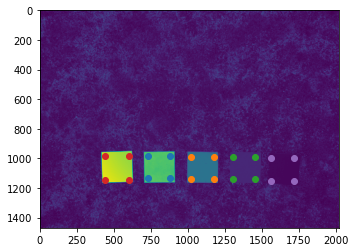

2


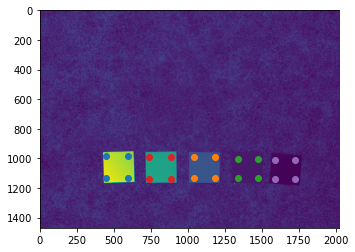

3


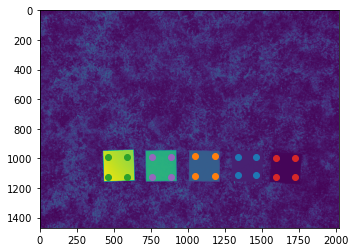

4


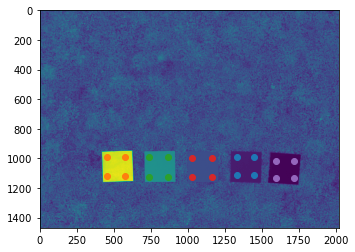

5


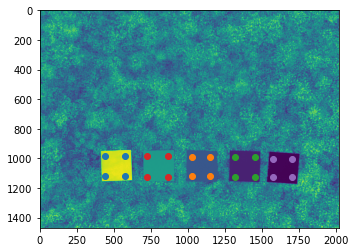

In [113]:
for idx, fn in enumerate(['data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/VO1nzxYiwuvEiiyo8Pg5.tif']):
    for j in range(1,6):
        xy_arrays = np.genfromtxt(xy_fns[j-1]).reshape(5,4,2)
        print(j)
        src = rasterio.open(fn)
        image = src.read(j)
        for i in range(5):
            plt.scatter(xy_arrays[i,:,0],xy_arrays[i,:,1])
        plt.imshow(image)
        plt.show()